# 환경 세팅

In [2]:
# numerical calculation & data frames
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

# statistics
import statsmodels.api as sm

# pandas options
pd.set_option('mode.copy_on_write', True)  # pandas 2.0
pd.options.display.float_format = '{:.2f}'.format  # pd.reset_option('display.float_format')
pd.options.display.max_rows = 7  # max number of rows to display

# NumPy options
np.set_printoptions(precision = 2, suppress=True)  # suppress scientific notation

# For high resolution display
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

In [1]:
# Build a rangeplot!
def rangeplot(df, x, y, color=None):
    return (
        so.Plot(df, x=x, y=y, color=color)
        .add(so.Range(), so.Est(errorbar=("pi", 50)), so.Dodge())
        .add(so.Dots(pointsize=8, marker="<"), so.Agg("median"), so.Dodge())
        .scale(color="Dark2")
        .theme({**sns.axes_style("whitegrid")})
    )

def boxplot(df, x, y, color=None, alpha=0.1):
    return (
        so.Plot(df, x=x, y=y, color=color)
        .add(so.Dots(alpha=alpha, color=".6"), so.Jitter(), so.Dodge())
        .add(so.Range(), so.Est(errorbar=("pi", 50)), so.Dodge())
        .add(so.Dots(pointsize=8, marker="<"), so.Agg("median"), so.Dodge())
        .scale(color="Dark2")
        .theme({**sns.axes_style("whitegrid")})
    )

In [29]:
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels.tools.eval_measures import rmse, meanabs

# 데이터 불러오기

In [4]:
# import the data
flights = sm.datasets.get_rdataset('flights', 'nycflights13').data

# convert the date column to a datetime object
flights["time_hour"] = pd.to_datetime(flights["time_hour"])

# add a column for the day of the week
flights["dow"] = (
    flights["time_hour"]
    .dt.day_name()
    .str[:3]
    .astype("category")
    .cat.set_categories(["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"])
)

# add a column for the season
flights["season"] = np.where(flights["month"].isin([6, 7]), "summer", "other month")

In [5]:
# filter out the flights to SFO
sfo = flights.query('dest == "SFO" & arr_delay < 500').copy()

In [16]:
sim1 = pd.read_csv("sim1.csv")
sim2 = pd.read_csv("sim2.csv")
sim3 = pd.read_csv("sim3.csv")

In [20]:
diamonds = sm.datasets.get_rdataset("diamonds", "ggplot2").data

# cut, color, clarity 모두 categorical type으로 변형
diamonds["cut"] = pd.Categorical(
    diamonds["cut"],
    categories=["Fair", "Good", "Very Good", "Premium", "Ideal"],
    ordered=True
)
diamonds["color"] = pd.Categorical(
    diamonds["color"],
    categories=["D", "E", "F", "G", "H", "I", "J"],
    ordered=True
)
diamonds["clarity"] = pd.Categorical(
    diamonds["clarity"],
    categories=["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"],
    ordered=True
)

In [37]:
flights = sm.datasets.get_rdataset('flights', 'nycflights13').data

# Make dates from year, month, day
flights["date"] = pd.to_datetime(flights[["year", "month", "day"]])

daily = flights.groupby("date").size().reset_index(name="n")

# 시각화

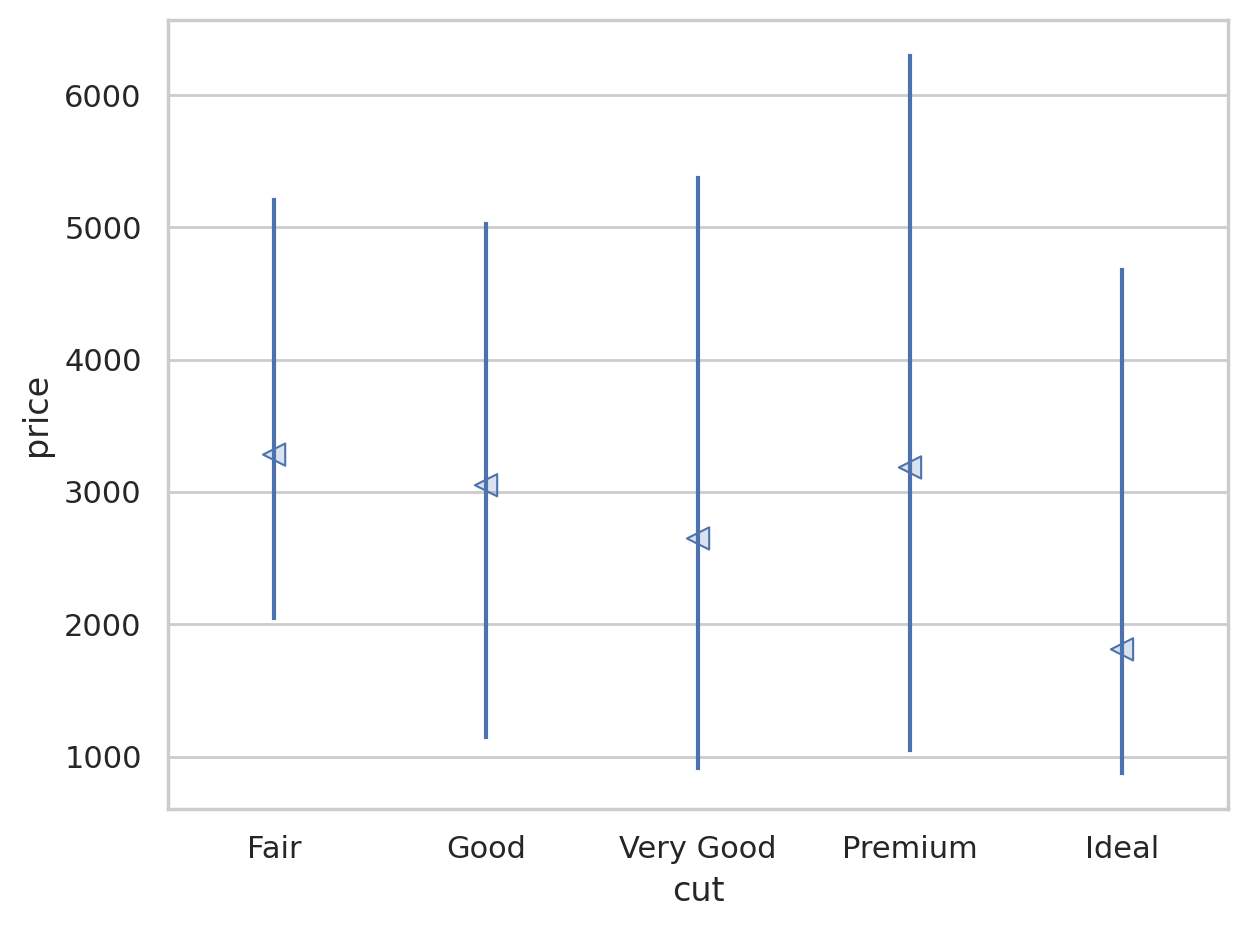

In [22]:
cut = rangeplot(diamonds, x="cut", y="price").show()

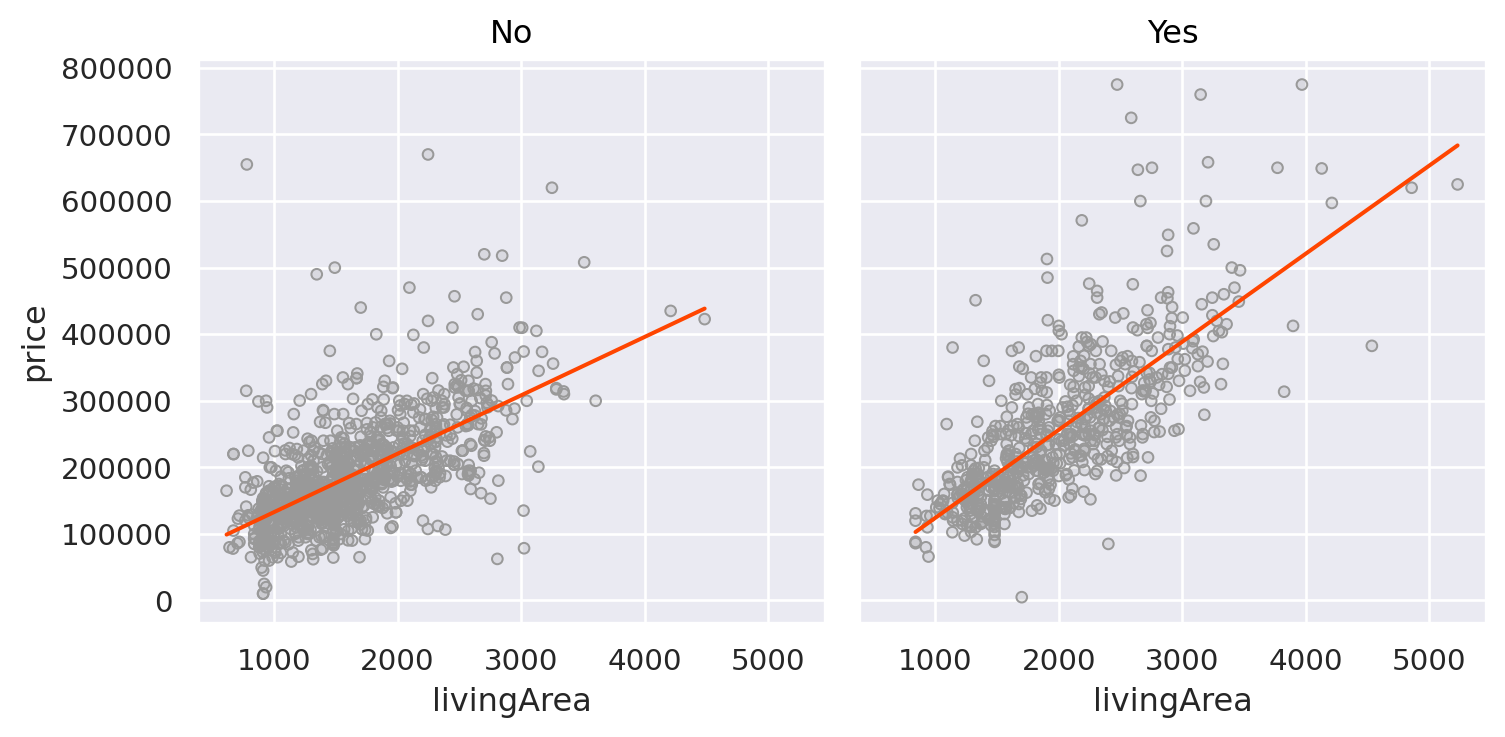

In [23]:
houses = sm.datasets.get_rdataset("SaratogaHouses", "mosaicData").data
(
    so.Plot(houses, x='livingArea', y='price')
    .add(so.Dots(color='.6'))
    .add(so.Line(color="orangered"), so.PolyFit(1))
    .facet("centralAir")
    .layout(size=(8, 4))
)

In [ ]:
(
    so.Plot(daily, x='date', y='resid')
    .add(so.Line())
    .add(so.Line(color="red", linestyle=":"), so.Agg(lambda x: 0))
    .layout(size=(8, 4))
)

# OLS estimation 코드

In [6]:
mod = ols("arr_delay ~ hour + origin + carrier + season + dow", data=sfo).fit()

In [17]:
# 상호 작용하는 경우 (:, * symbol 사용)
mod2 = ols('y ~ x1 * x2', data=sim3).fit() # 같은 의미 'y ~ x1 + x2 + x1:x2'

In [ ]:
# robust regression
mod3 = sm.RLM.from_formula("n ~ wday * term", data=daily).fit()

## 잔차 구하기 및 시각화

In [7]:
sfo["resid"] = mod.resid

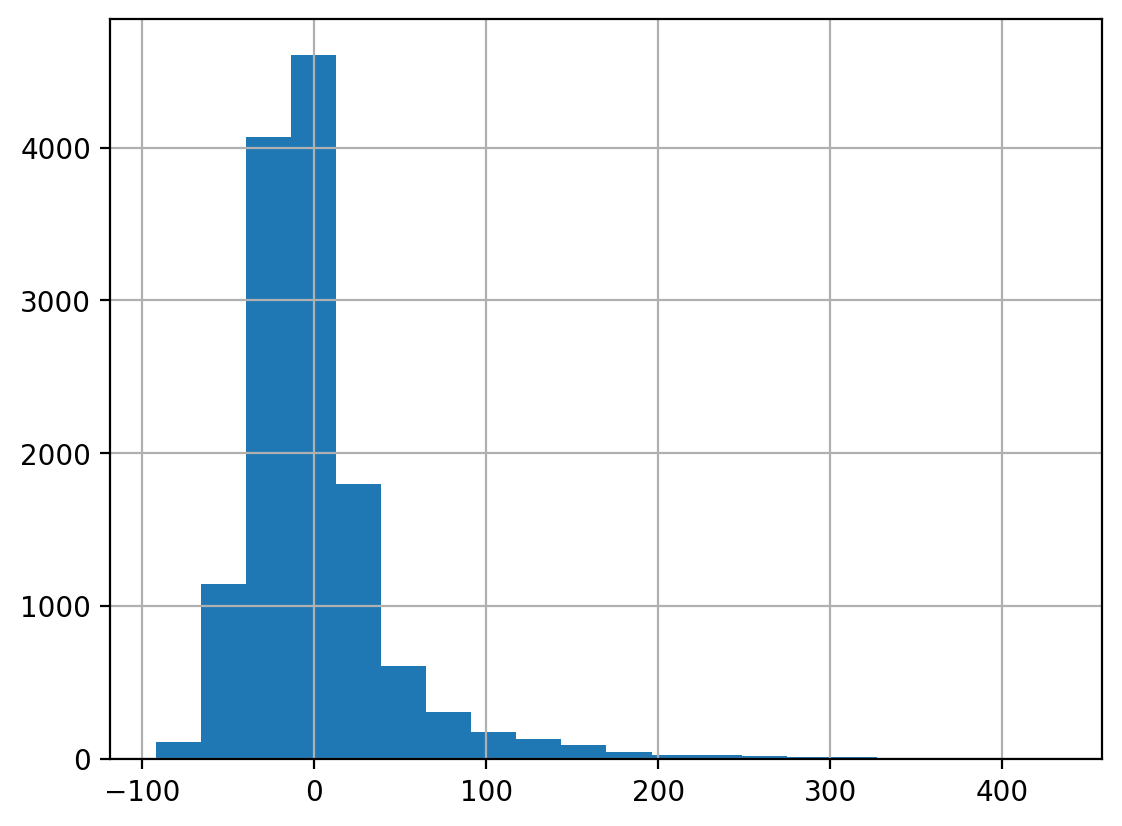

In [10]:
sfo["resid"].hist(bins=20)
plt.show()

## 파라미터 구하기

In [9]:
mod.params

Intercept       -20.44
origin[T.JFK]     4.16
carrier[T.B6]    -9.58
                 ...  
dow[T.Fri]       -4.95
dow[T.Sat]      -10.40
hour              2.07
Length: 14, dtype: float64

## 예측의 정확도인 RMSE, MAE, R_squared 계산하기

In [28]:
ypred = mod.predict(sfo)
y = sfo["arr_delay"]

print(f"RMSE = {rmse(y, ypred):.2f}")
print(f"MAE = {meanabs(y, ypred):.2f}")
print(f"R-squared = {mod.rsquared:.2f}")

RMSE = 43.67
MAE = 28.28
R-squared = 0.10


## 요약 테이블 출력

In [8]:
display(mod.summary().tables[0], mod.summary().tables[1])

Dep. Variable:,arr_delay,R-squared:,0.096
Model:,OLS,Adj. R-squared:,0.095
Method:,Least Squares,F-statistic:,107.0
Date:,"Mon, 10 Jun 2024",Prob (F-statistic):,8.13e-275
Time:,10:23:58,Log-Likelihood:,-68419.
No. Observations:,13169,AIC:,1.369e+05
Df Residuals:,13155,BIC:,1.370e+05
Df Model:,13,,
Covariance Type:,nonrobust,,


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-20.4363,2.116,-9.660,0.000,-24.583,-16.289
origin[T.JFK],4.1590,0.966,4.306,0.000,2.266,6.052
carrier[T.B6],-9.5832,1.807,-5.302,0.000,-13.126,-6.040
carrier[T.DL],-17.9685,1.553,-11.571,0.000,-21.012,-14.925
carrier[T.UA],-4.0238,1.424,-2.826,0.005,-6.815,-1.232
carrier[T.VX],-4.9082,1.537,-3.194,0.001,-7.921,-1.896
season[T.summer],24.6238,0.991,24.838,0.000,22.681,26.567
dow[T.Mon],-2.6982,1.424,-1.895,0.058,-5.489,0.093
dow[T.Tue],-6.0939,1.423,-4.282,0.000,-8.883,-3.304
dow[T.Wed],-5.3144,1.425,-3.728,0.000,-8.108,-2.520


# 로그 취하기

In [25]:
diamonds2 = diamonds.query("carat < 2.5").assign(
    lprice=lambda x: np.log2(x.price),
    lcarat=lambda x: np.log2(x.carat)
)

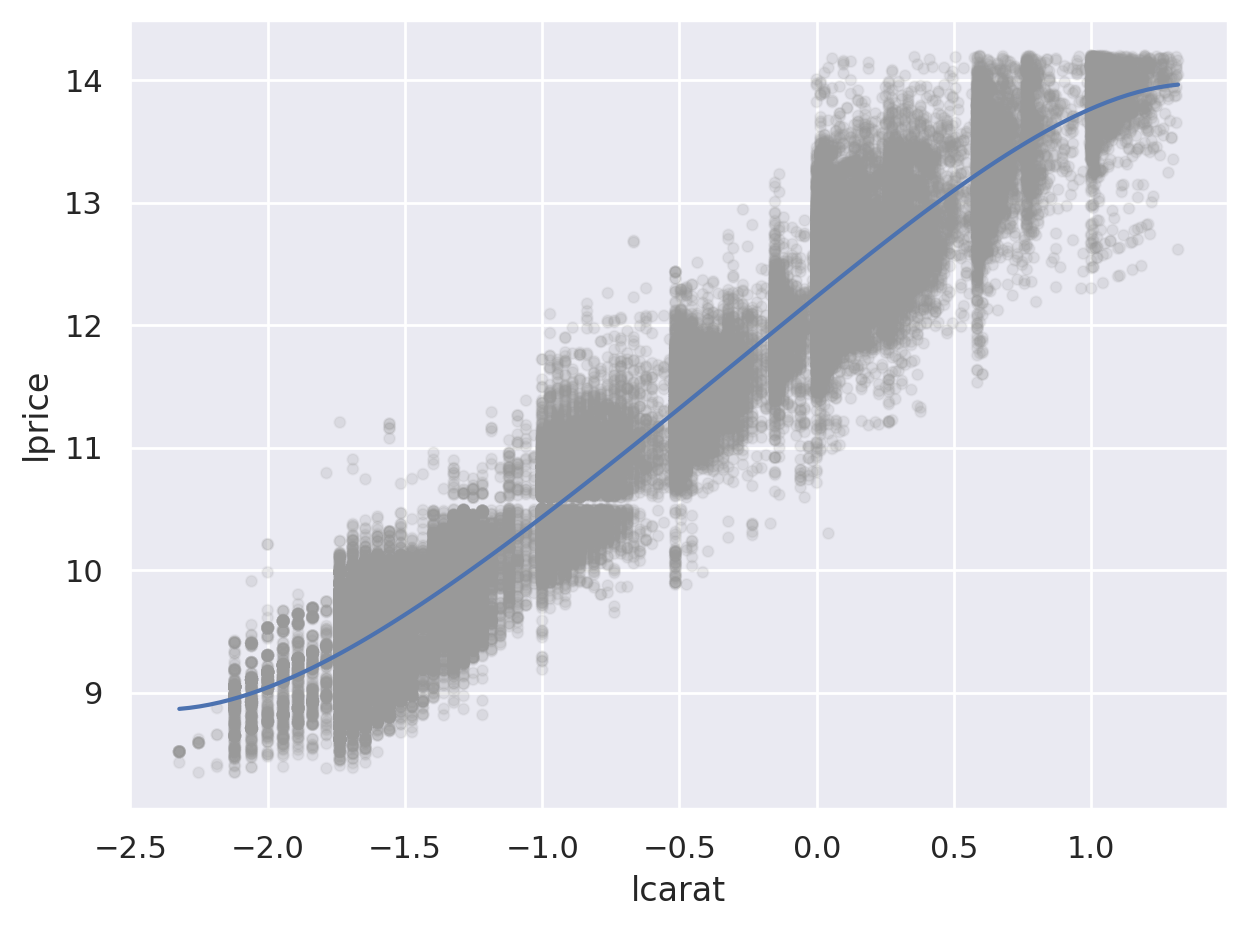

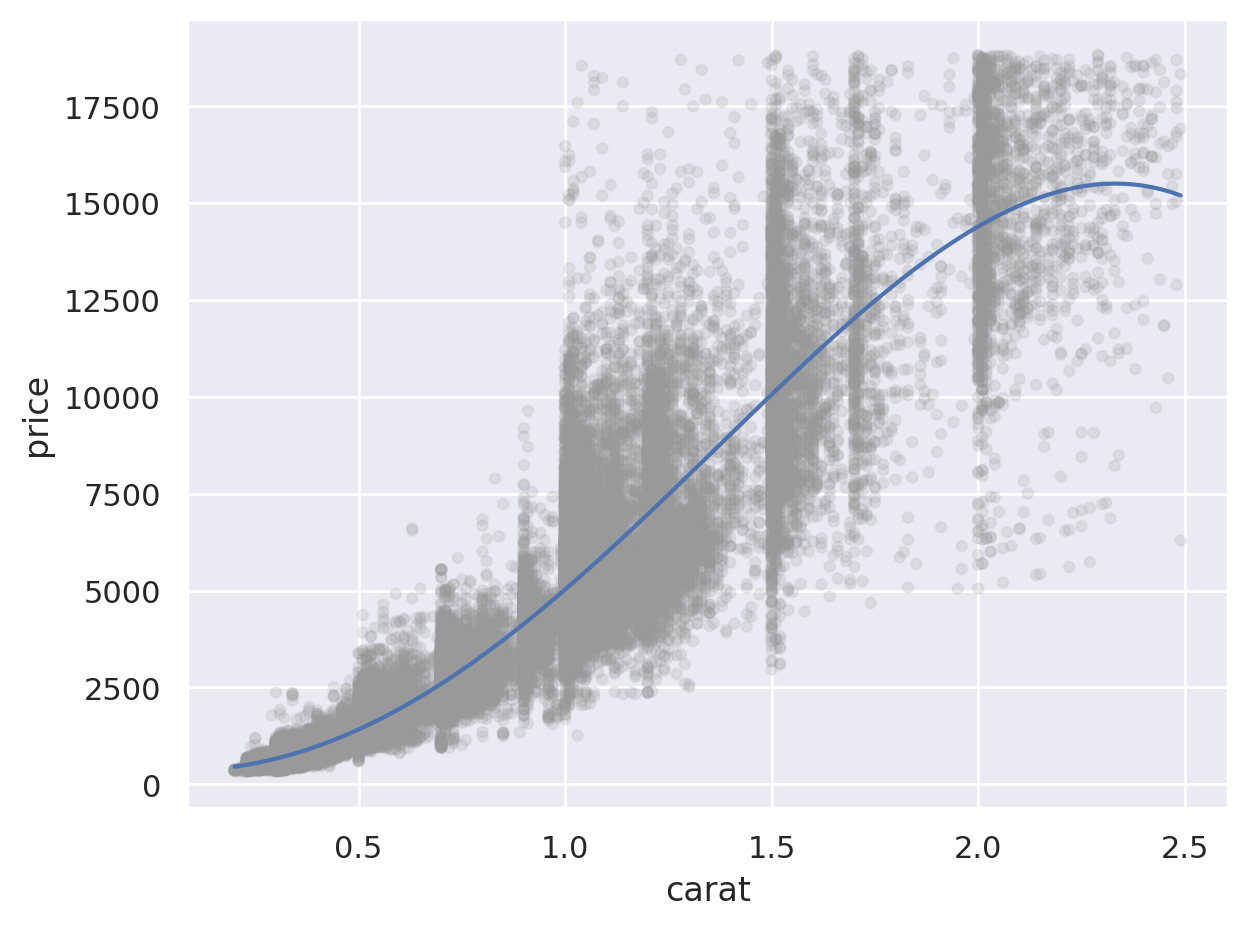

In [26]:
log_plot = (
    so.Plot(diamonds2, x="lcarat", y="lprice")
    .add(so.Dots(color=".6", alpha=0.1))
    .add(so.Line(), so.PolyFit(5))
).show()

plot = (
    so.Plot(diamonds2, x="carat", y="price")
    .add(so.Dots(color=".6", alpha=0.1))
    .add(so.Line(), so.PolyFit(5))
).show()

# grid 만들기

## 연속형 변수 1개

In [18]:
grid = pd.DataFrame(dict(x=np.linspace(sim1.x.min(), sim1.x.max(), 10)))   #


# a model for sim1

sim1_mod = ols("y ~ x", data=sim1).fit()

grid["pred"] = sim1_mod.predict(grid) # column 이름이 매치되어야 함
grid

       x
0   1.00
1   2.00
2   3.00
..   ...
7   8.00
8   9.00
9  10.00

[10 rows x 1 columns]


,x,pred
0,1.00,6.27
1,2.00,8.32
2,3.00,10.38
...,...,...
7,8.00,20.63
8,9.00,22.68
9,10.00,24.74


# 범주형 변수 1개로 만들기

In [ ]:
# Prediction
grid = pd.DataFrame({"wday": ["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"]})
grid["pred"] = mod.predict(grid)
grid

## 카테고리 1개 빼고 나머지는 고정하는 방식

In [30]:
mod_full = smf.ols('lprice ~ lcarat + cut + color + clarity', data=diamonds2).fit()

# 연속 변수는 보통 평균이나 중앙값
# 카테고리 변수는 보통 최빈값 사용

grid = pd.DataFrame({"cut": ["Fair", "Good", "Very Good", "Premium", "Ideal"]})
grid["color"] = diamonds2.color.mode()[0]  # mode: 최빈값
grid["clarity"] = diamonds2.clarity.mode()[0]
grid["lcarat"] = diamonds2.lcarat.median()

grid

,cut,color,clarity,lcarat
0,Fair,G,SI1,-0.51
1,Good,G,SI1,-0.51
2,Very Good,G,SI1,-0.51
3,Premium,G,SI1,-0.51
4,Ideal,G,SI1,-0.51


In [31]:
grid["lpred"] = mod_full.predict(grid)
grid["pred"] = 2**grid.lpred  # 원래 단위인 price로 되돌리기
grid

,cut,color,clarity,lcarat,lpred,pred
0,Fair,G,SI1,-0.51,10.99,2035.36
1,Good,G,SI1,-0.51,11.10,2202.21
2,Very Good,G,SI1,-0.51,11.16,2285.37
3,Premium,G,SI1,-0.51,11.19,2337.24
4,Ideal,G,SI1,-0.51,11.22,2388.52


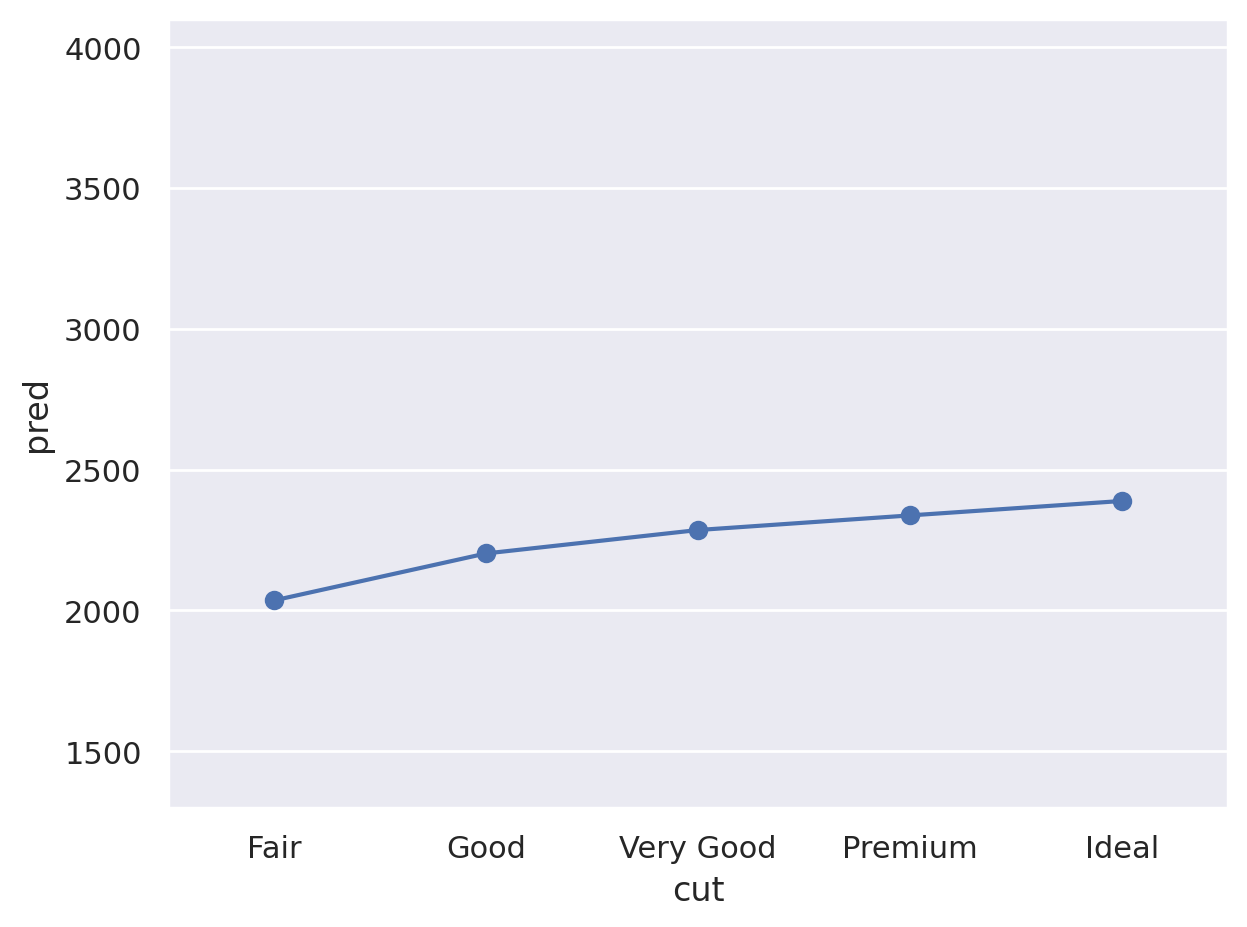

In [32]:
(
    so.Plot(grid, x='cut', y='pred')
    .add(so.Line(marker="o"))
    .limit(y=(1300, 4100))  # 아래 플랏과 비교하기 위해 y축 범위를 고정
).show()

# melt 활용하여 long_format 만들기

     x1 x2 model  resid
0     1  a  mod1  -2.25
1     1  a  mod1  -0.49
2     1  a  mod1   0.56
..   .. ..   ...    ...
237  10  d  mod2   2.59
238  10  d  mod2   1.08
239  10  d  mod2   1.16

[240 rows x 4 columns]


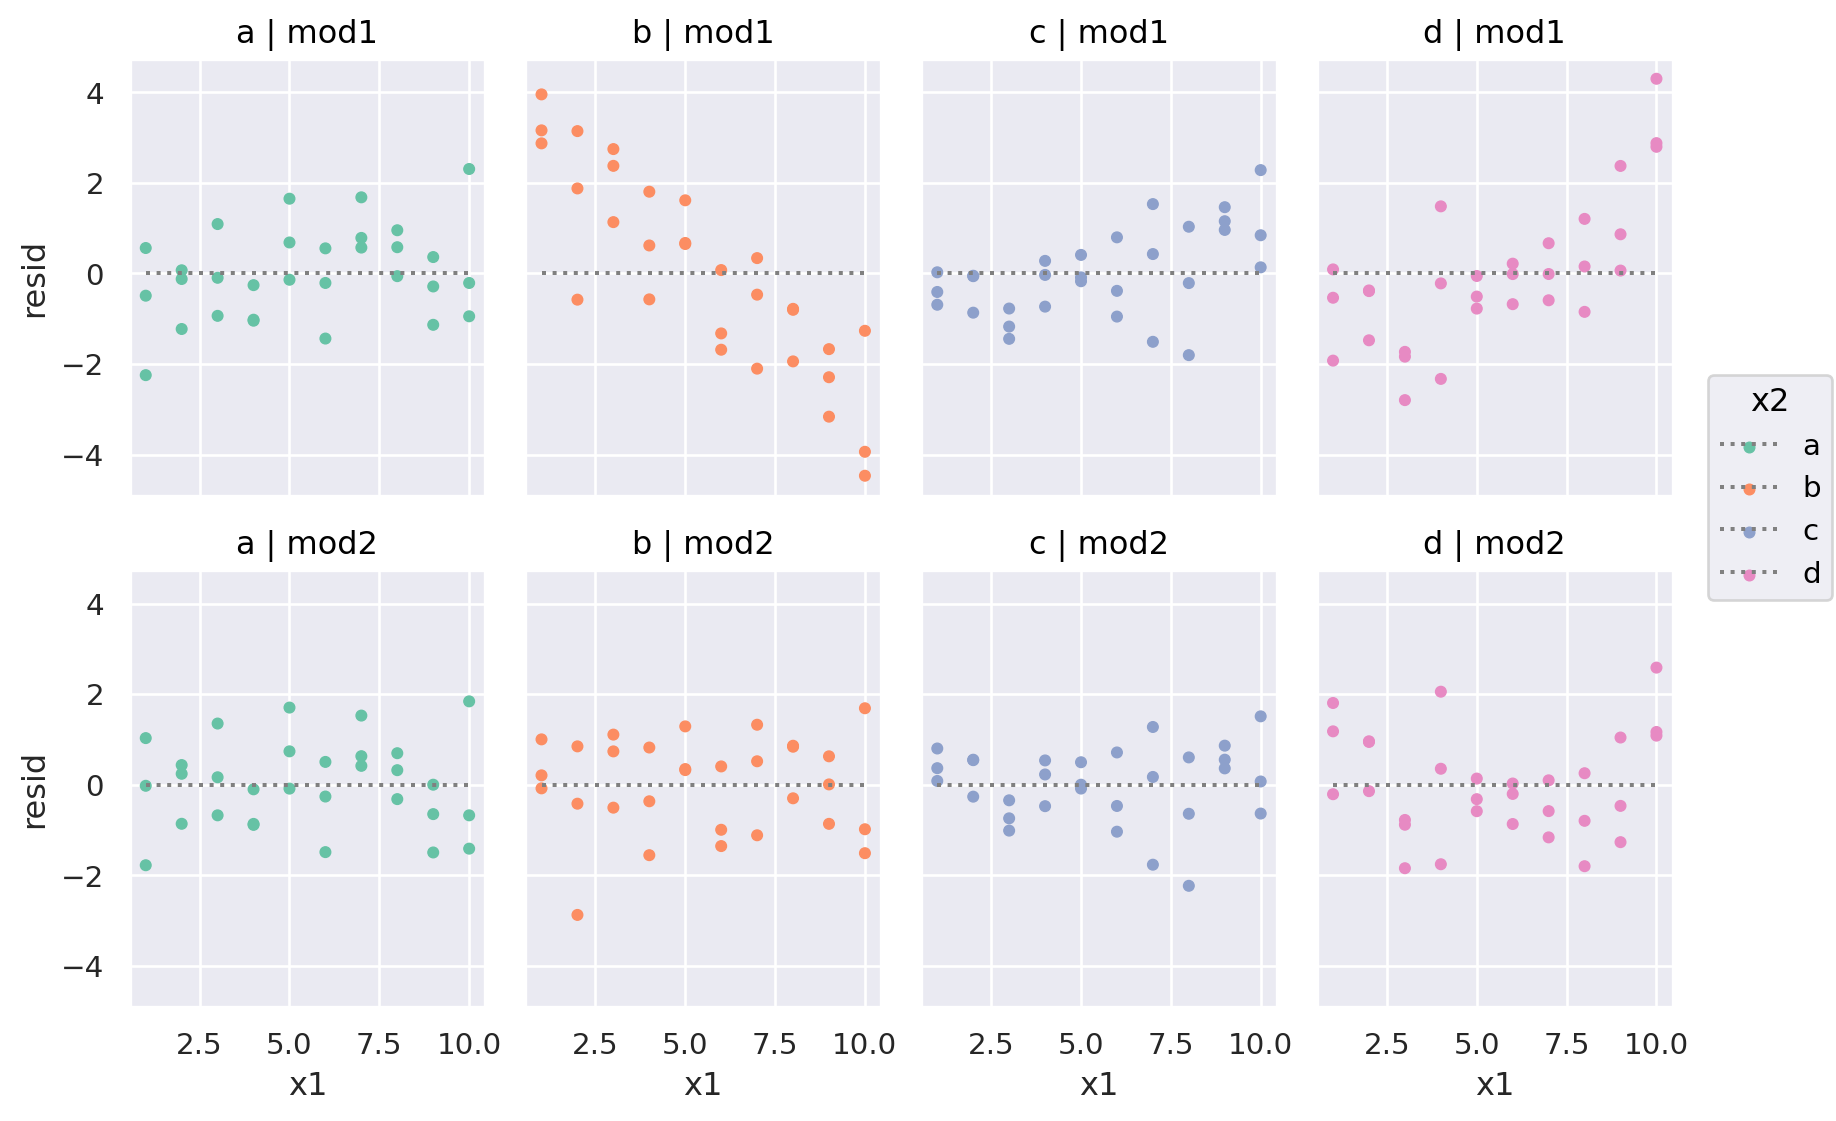

In [34]:
mod1 = ols('y ~ x1 + x2', data=sim3).fit()
mod2 = ols('y ~ x1 * x2', data=sim3).fit() # 같은 의미 'y ~ x1 + x2 + x1:x2'

sim3["mod1"] = mod1.resid
sim3["mod2"] = mod2.resid

sim3_long = sim3.melt(
    id_vars=["x1", "x2"],
    value_vars=["mod1", "mod2"],
    var_name="model",
    value_name="resid",
)

print(sim3_long)

(
    so.Plot(sim3_long, x="x1", y="resid", color="x2")
    .add(so.Dot(pointsize=4))
    .add(so.Line(linestyle=":", color=".5"), so.Agg(lambda x: 0))
    .facet("x2", "model")
    .layout(size=(9, 6))
    .scale(color="Set2")
)

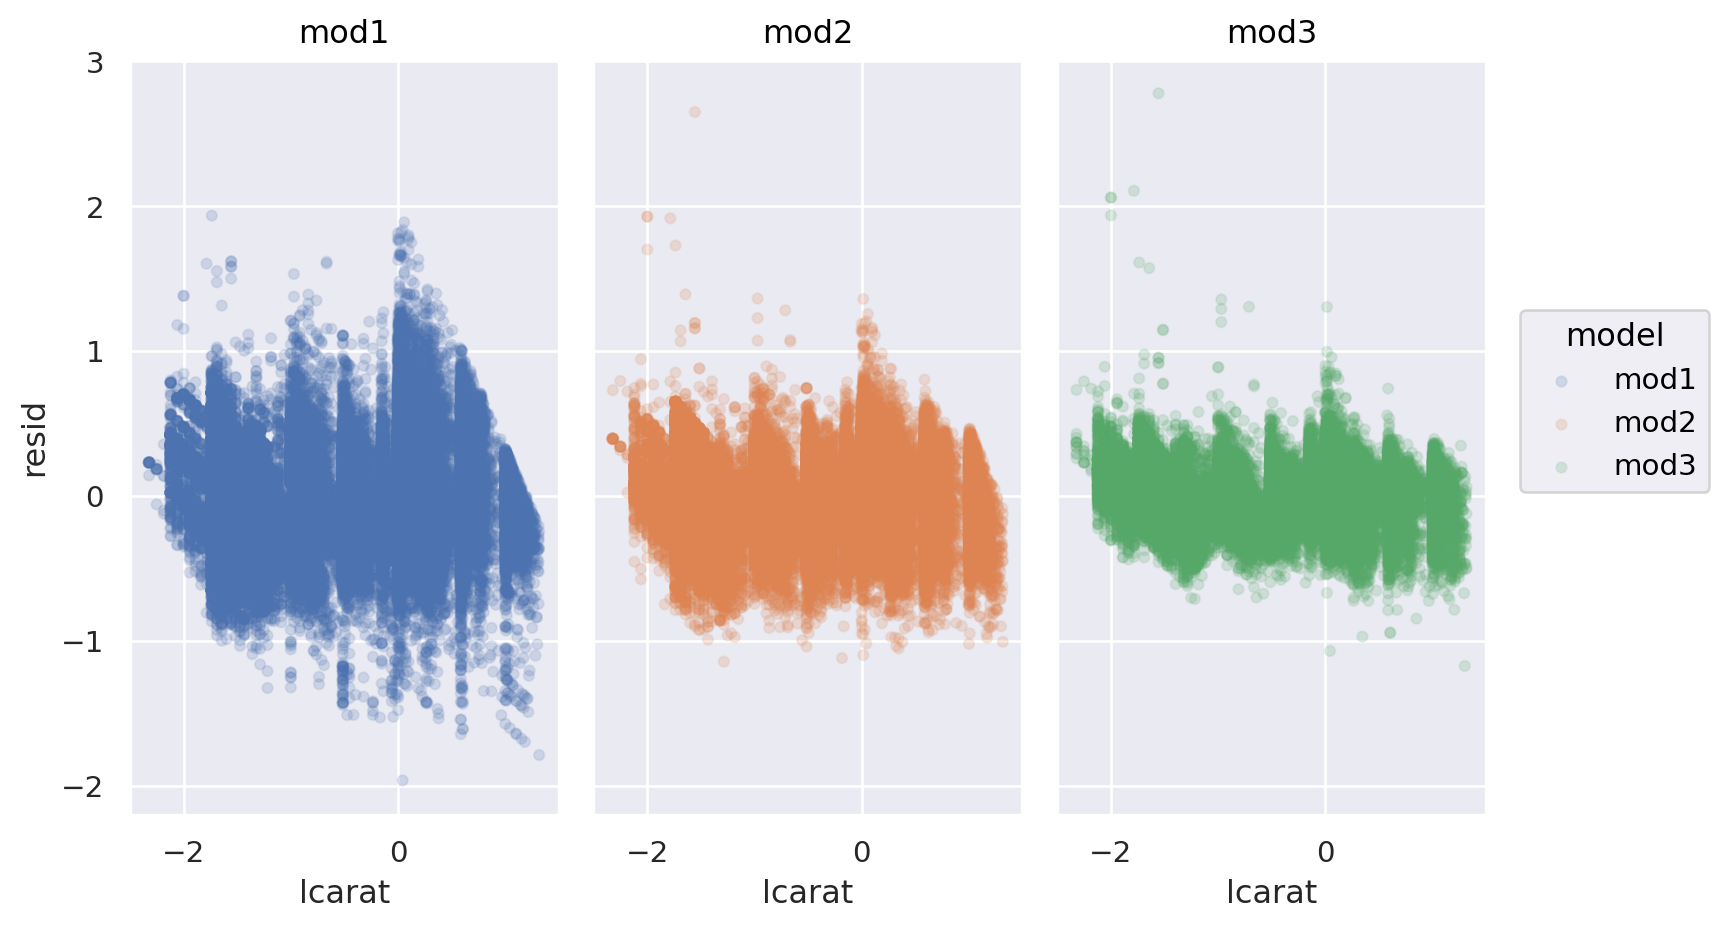

In [35]:
# Nested models
diamonds2_mod1 = smf.ols("lprice ~ lcarat", data=diamonds2).fit()
diamonds2_mod2 = smf.ols("lprice ~ lcarat + clarity", data=diamonds2).fit()
diamonds2_mod3 = smf.ols("lprice ~ lcarat + cut + color + clarity", data=diamonds2).fit()

diamonds2_mods = diamonds2.assign(
    mod1=diamonds2_mod1.resid,
    mod2=diamonds2_mod2.resid,
    mod3=diamonds2_mod3.resid,
)

diamonds2_mods = diamonds2_mods.melt(
    id_vars=["lcarat", "lprice"],
    value_vars=["mod1", "mod2", "mod3"],
    var_name="model",
    value_name="resid",
)

(
    so.Plot(diamonds2_mods, x='lcarat', y='resid', color='model')
    .add(so.Dots(alpha=.1))
    .facet("model")
    .layout(size=(8, 5))
)

# 모델 비교

In [41]:
mod = ols("arr_delay ~ hour + origin + carrier + season + dow", data=sfo).fit()

# origin removed
mod1 = ols("arr_delay ~ hour + carrier + season + dow", data=sfo).fit()

# carrier removed
mod2 = ols("arr_delay ~ hour + season + dow", data=sfo).fit()

print(f"R-squared: {mod.rsquared:.3f}, {mod1.rsquared:.3f}, {mod2.rsquared:.3f}")

R-squared: 0.096, 0.094, 0.084
